# Interfacing binarycpython &  MCMC
This notebook will show an example on how to use MCMC (with [emcee](https://emcee.readthedocs.io/)) with binary_c.

We will set up a MCMC simulation to sample the initial mass and metallicity to find those that end up as a black hole with a certain mass + error. 

Technically we want to do the following:
- [ ] Create a simple model: vary mass and metallicity to find the range that fits the given black hole mass of 50solm. I.e. theta consists of M1 and metallicity. 
- [ ] Give the model a certain weight score based on the total mass of the black hole

This script contains the following parts:
- [ ] Setting up binarycpython
- [ ] Setting up the emcee functions (or any other MCMC sampler)
- [ ] Running the sampler.
- [ ] Plotting the results

## Backup reading
This script is based on the scripts within https://github.com/prappleizer/prappleizer.github.io/tree/master/Tutorials/MCMC and I highly recommend going through that notebook before running the functions here. That notebook is explained way more detailed then this notebook. 

### Other stuff
- [ ] https://stackoverflow.com/questions/49810234/using-emcee-with-gaussian-priors

In [2]:
# Import the necessary packages
import time

import emcee
import corner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from multiprocessing import Pool

import binarycpython
from binarycpython.utils.grid import Population

## binarycpython functions
Here we set up the functions to run binarycpython and interface with binary_c

We need to do the following things:
- [ ] Setting up the parse function to read out the data
- [ ] Setting up the function through which we call binary_c: either through the population object, via run_wrapper or via direct API calls
- [ ] Setting up custom logging memory and store memory

In this case I've chosen to call the objects through the population object's evolve_single().

For more information on how to run systems please see the [documentation](https://ri0005.pages.surrey.ac.uk/binary_c-python/modules.html) or [example notebooks](https://ri0005.pages.surrey.ac.uk/binary_c-python/example_notebooks.html)

In [3]:
def parse_function(self, output):
    """
    Function to extract the data from the output,
    
    The way we do it this time allows us to read out more than 1 timestep from the system
    """

    matched_lines = []

    if output:
        for line in output.splitlines():
            headerline = line.split()[0]

            # Check the header and act accordingly
            if (headerline=='EXAMPLE_MCMC'):
                parameters = [
                    'time', 
                    'mass_1', 'stellar_type', 'probability', 
                ]
                values = line.split()[1:]
                values = [float(i) for i in values]

                # Check whether the amount of parameters is the same as amount of values
                if not len(values)==len(parameters):
                    print("Length of readout vaues is not equal to length of parameters")
                    raise ValueError

                # Add matched lines to list
                matched_lines.append(values)
    else:
        print("binary_c returned None. There might be something wrong.")

    return matched_lines

# Create a store memory capsule
store_mem_caps = binarycpython._binary_c_bindings.return_store_memaddr()

# Set up population object
mcmc_pop = Population()

# Pass some settings
mcmc_pop.set(
    # Signal that we use single systems (multiplicty=1)
    multiplicity=1,

    # Set max time
    max_evolution_time=15000,

    # Turn off any extra logging
    verbosity=0,
    
    # Set the parse function
    parse_function=parse_function,

    # Set the store memory
    _store_memaddr=store_mem_caps,
)

# Create a custom logging routine that logs the formation of a black hole
custom_logging_string = """
if(stardata->star[0].stellar_type==14)
{
    if (stardata->model.time < stardata->model.max_evolution_time)
    {
        Printf("EXAMPLE_MCMC %30.12e " // 1
            "%g %d %g\\n", // 10-13

            //
            stardata->model.time, // 1

            stardata->star[0].mass, // 2
            stardata->star[0].stellar_type, // 3
            stardata->model.probability // 4
        );
    };
    /* Kill the simulation to save time */
    stardata->model.max_evolution_time = stardata->model.time - stardata->model.dtm;
};
"""

# Set the custom logging in the code
mcmc_pop.set(
    C_logging_code=custom_logging_string
)

## Emcee functions 
Now we will define the functions that are used in the emcee sampler.

We need to create the following functions:
- [ ] model: Create a method that calls the binarycpython function from above.
- [ ] lnlike: Create a method that rates the results of binarycpython.
- [ ] lnprob: Create prior functions for all the parameters we want to do sampling for.
- [ ] main: Function to actually call the MCMC sampler.

In [4]:
def model(theta):
    """
    Function that represents the model(data), instead of the observation data.

    This function handles calling binary_c with the parameters contained in theta,
    and return that output of binary_c.
    """
    
    # Readout the parameters
    M_1, metallicity = theta
    
    # Set them into the population object
    mcmc_pop.set(
        M_1=M_1, 
        metallicity=metallicity
    )
    
    # Evolve the system and fetch the output.
    # The raw output is parsed through the parse function, we set that above.
    output = mcmc_pop.evolve_single(clean_up_custom_logging_files=False)

    # Return output
    return output

def lnlike(theta):
    """
    Function to calculate the loglikelihood for the modeldata

    First we call the model to generate the data,
    then we check if the information we want is contained in there,
    and then we calculate a score based on the output.

    This function can be modified to take into account more quantities
    """
    
    # Call model
    model_output = model(theta)

    # Set bh_mass = 0 to make sure it exists. Then read out the data
    # Here we can improve looping over each element of model_output
    # to find the one with the largest score
    bh_mass = 0
    if model_output:e
        for line in model_output:
            if int(line[2])==14:
                bh_mass = line[1]

    # The further apart the numbers are, the more negative they are. 
    # the closer they get to eachother, the closer to 0 we get. 
    score = -0.5 * ((50 - bh_mass)/(0.05 * 50))**2

    return score

def lnprior(theta):
    """
    Function to calculate the prior based on the input parameters.

    In this current case we use a flat prior for all the parameters.

    This is a very basic example of setting the prior.
    """

    # read out the parameters
    M_1, metallicity = theta

    # Calculate the priors. We use 0 if we are in the domain we want, and otherwise -np.inf
    if (0 < M_1 < 300) and \
    (0.0002 < metallicity < 0.02):
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    """
    Function to calculate the combination of the log likelihood and the log prior
    """
    
    # Call ln prior function to get the priors
    lp = lnprior(theta)
    if not np.isfinite(lp): # if we are outside of the prior we return -np.inf to indicate that we are outside of the valid domain
        return -np.inf
    
    # Calculate the likelihood, combine that with the prior and return
    return lp + lnlike(theta)

def main(p0, nwalkers, niter, niter_burnin, ndim, lnprob_function, cores=1):
    """
    Function to actually run the emcee sampler within a multiprocessing environment.
    
    We start with the burn-in phase, where we do <niter_burning> amount of iterations. 
    TODO: Paula, do you have a suggestion on the size of this burn-in phase?
    """

    # Set up the multiprocessing environment and run the sampler within it
    with Pool(cores) as pool:
        
        # Set up the sampler
        sampler = emcee.EnsembleSampler(
            nwalkers=nwalkers,
            ndim=ndim,
            log_prob_fn=lnprob_function,
            pool=pool
        )
    
        # Run the burn-in
        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, niter_burnin) # burn in and update the initial guess
        sampler.reset() # Reset the sampler. TODO: Paula, do you know why?

        # Run the actual run
        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    # Return all the info
    return sampler, pos, prob, state

## Emcee configuration
Now that we have created the functions to call the emcee, we need to configure our actual emcee run. 

In [15]:
nwalkers = 20 # Set the amount of walkers
niter = 1000 # Set the amount of iterations for the walkers
ndim = 2 # Dimensions of the parameter space
niter_burnin = 10

# Span a grid of initial guesses: TODO: paula, is this true?
xx = np.arange(0, 300, 1)
yy= np.arange(0.0002, 0.02, 0.0002)

# Pick randomly a set of initial guesses from the grid we generated
p0 = [
    np.array(
        [
            np.random.choice(xx, size=1)[0],
            np.random.choice(yy, size=1)[0]
        ]
    ) for i in range(nwalkers)
]

## Running the walkers
Below we run the simulation

In [16]:
# Amount of cores
cores = 2

# Call the 
start = time.time()
sampler, pos, prob, state = main(
    p0,
    nwalkers,
    niter,
    niter_burnin,
    ndim,
    lnprob,
    cores
)
stop = time.time()
spent_time = stop-start

print("Running the walkers on {} cores took {} seconds.".format(cores, spent_time))

Running burn-in...
Running production...


100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]

Running the walkers on 2 cores took 737.9244470596313 seconds.


# Analysing the results
After running the sampler we can now plot the results, and decide whether we need to run it for a longer time, and which part of the chains are actually non converged and should be regarded as part of the burn-in phase.

/home/david/.pyenv/versions/3.6.4/envs/dev-binarycpython3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


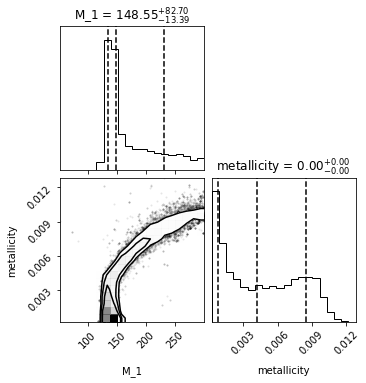

In [17]:
samples = sampler.flatchain

labels = ['M_1','metallicity']
fig = corner.corner(
    samples,
    show_titles=True,
    labels=labels,
    plot_datapoints=True, 
    quantiles=[0.16, 0.5, 0.84]
)
fig.show()

Plotting the chains:

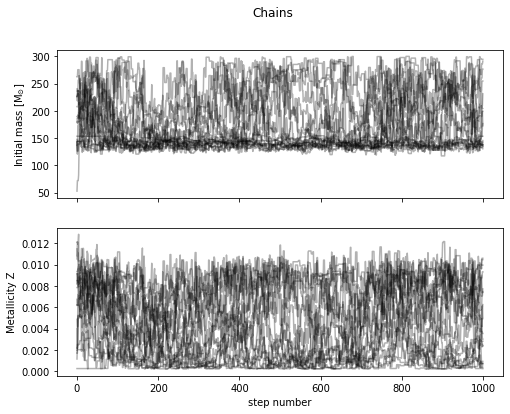

In [18]:
labels = [r"Initial mass [M$_{\odot}$]", "Metallicity Z"]

#
fig, axes = plt.subplots(nrows=ndim, ncols=1, figsize=(8, 6), sharex=True)

# Read out the samples
chains = sampler.get_chain()

for i in range(ndim):
    axes[i].plot(chains[:, :, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    
# Some make up
plt.suptitle("Chains")
axes[-1].set_xlabel("step number")

#
plt.show()

Autocorrelation analysis: NOT DONE YET!

In [ ]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

## Clean up the binary_c stuff
At the end of this script we need to free the store memory and make sure to clean up the binary_c custom logging if we used it

In [ ]:
# Delete the memory adress
binarycpython._binary_c_bindings.free_store_memaddr(store_mem_caps)
mcmc_pop.set(_store_memaddr=-1)
del store_mem_caps

# Clean the custom logging
mcmc_pop._clean_up_custom_logging(evol_type="single")